In [1]:
# Load datasets from saved pickle files
import pandas as pd
import os

import os, json, pickle, random, time

import xgboost as xgb
import numpy as np
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    precision_recall_curve, auc,
    accuracy_score
)

from sklearn.utils import compute_sample_weight



In [2]:
# Enhanced Training Loop with SMOTE, Group‐Aware CV, Correlation Pruning, and SHAP‐Based Feature Selection
import os
import pickle
import random
import time
import json

import numpy as np
import pandas as pd
import xgboost as xgb
import shap

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import f1_score, classification_report
from sklearn.model_selection  import GroupKFold
from sklearn.utils            import compute_sample_weight
from imblearn.over_sampling   import SMOTE

# ————————————————————————————————————————————————
# 1) Drop Highly Correlated Features from X_train.
def drop_correlated_features(X: pd.DataFrame, threshold: float = 0.95):
    """
    Returns X_reduced, list_of_dropped_columns.
    Drops any feature that has |corr| ≥ threshold with a previously-kept feature.
    """
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] >= threshold)]
    X_reduced = X.drop(columns=to_drop)
    return X_reduced, to_drop

# ————————————————————————————————————————————————
# 2) SHAP‐Based Feature Selection with Safe SMOTE
def select_top_shap_features(
    X_train: pd.DataFrame,
    y_train_num: np.ndarray,
    n_top: int = 50,
    smote_ratio: float = 0.3
):
    """
    1) If minority_class_count < smote_ratio * majority_class_count, use SMOTE to oversample
       minority to smote_ratio of majority. Otherwise, skip SMOTE (sampling_strategy='auto').
    2) Train a quick XGB on that (possibly oversampled) data.
    3) Compute SHAP values and return top n_top features by mean absolute SHAP.
    """
    # Determine class counts
    classes, counts = np.unique(y_train_num, return_counts=True)
    # classes[0] might be LVOT or RVOT encoded; we find majority/minority by counts
    maj_count = counts.max()
    min_count = counts.min()
    # majority_class = classes[np.argmax(counts)]
    # minority_class = classes[np.argmin(counts)]
    desired_min = int(maj_count * smote_ratio)

    if min_count < desired_min:
        sampling_strategy = {classes[np.argmin(counts)]: desired_min}
    else:
        sampling_strategy = "auto"

    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_tr_over, y_tr_over = sm.fit_resample(X_train, y_train_num)

    # Train a lightweight XGBoost
    baseline = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="aucpr",
        random_state=42
    )
    baseline.fit(X_tr_over, y_tr_over, verbose=False)

    # Compute SHAP on the oversampled data
    explainer = shap.TreeExplainer(baseline)
    shap_vals = explainer.shap_values(X_tr_over)
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    feat_importance = pd.Series(mean_abs_shap, index=X_train.columns)
    top_features = feat_importance.sort_values(ascending=False).head(n_top).index.tolist()
    return top_features

# ————————————————————————————————————————————————
# 3) CV Macro‐F1 with GroupKFold + SMOTE in Each Fold
def cv_macro_f1_grouped_oversample(
    params,
    X: pd.DataFrame,
    y_num: np.ndarray,
    groups: pd.Series,
    smote_ratio: float = 0.3,
    n_splits: int = 5
):
    """
    GroupKFold ensures no patient appears in both train/val in any fold.
    Within each fold:
      - Possibly SMOTE‐oversample train portion to smote_ratio of majority.
      - Train XGB(**params), predict on val, sweep threshold in [0.01,0.99] for best macro-F1.
      - Return mean of fold‐wise best macro-F1 scores.
    """
    gkf = GroupKFold(n_splits=n_splits)
    fold_scores = []
    thresh_candidates = np.arange(0.01, 1.00, 0.01)

    for tr_idx, val_idx in gkf.split(X, y_num, groups=groups):
        X_tr_f,  X_val_f  = X.iloc[tr_idx],  X.iloc[val_idx]
        y_tr_f,  y_val_f  = y_num[tr_idx],   y_num[val_idx]

        # Determine SMOTE strategy for this fold
        classes, counts = np.unique(y_tr_f, return_counts=True)
        maj_count = counts.max()
        min_count = counts.min()
        desired_min = int(maj_count * smote_ratio)

        if min_count < desired_min:
            sampling_strategy = {classes[np.argmin(counts)]: desired_min}
        else:
            sampling_strategy = "auto"

        sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_tr_over, y_tr_over = sm.fit_resample(X_tr_f, y_tr_f)

        sw_tr_over = compute_sample_weight("balanced", y_tr_over)

        model = xgb.XGBClassifier(**params)
        model.fit(
            X_tr_over,
            y_tr_over,
            sample_weight = sw_tr_over,
            eval_set = [(X_val_f, y_val_f)],
            sample_weight_eval_set = [compute_sample_weight("balanced", y_val_f)],
            verbose=False
        )

        proba_val_f = model.predict_proba(X_val_f)[:, 1]

        best_fold_f1 = 0.0
        for t in thresh_candidates:
            preds_t = (proba_val_f >= t).astype(int)
            fold_f1 = f1_score(y_val_f, preds_t, average='macro')
            if fold_f1 > best_fold_f1:
                best_fold_f1 = fold_f1

        fold_scores.append(best_fold_f1)

    return np.mean(fold_scores)

# ————————————————————————————————————————————————
# 4) Main Random Search Function
def random_search_xgb_enhanced(
    X_train_full: pd.DataFrame,
    y_train_full: pd.Series,
    patients_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    patients_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    patients_test: pd.Series,
    param_space: dict,
    results_path: str,
    best_model_bin: str,
    corr_threshold: float = 0.95,
    shap_top_k: int = 50,
    smote_ratio: float = 0.3,
    n_splits: int = 5
):
    """
    1) Drop highly correlated features in X_train_full (corr_threshold).
    2) Label‐encode y_train_full and pass numeric labels to SHAP‐selection.
    3) SHAP‐select top shap_top_k features (with SMOTE).
    4) Reduce X_train_full, X_val, X_test to those top features.
    5) Encode labels for train/val/test and compute val sample weights.
    6) Run random search:
       - CV with GroupKFold+SMOTE, final train+threshold sweep, test eval.
       - Save best model and history.
    """
    # — Step 4.1: Drop correlated features
    print("Dropping correlated features (threshold=%.2f)..." % corr_threshold)
    X_train_no_corr, dropped_corr = drop_correlated_features(X_train_full, threshold=corr_threshold)
    print(f"Dropped {len(dropped_corr)} features:", dropped_corr, "\n")

    X_val_no_corr  = X_val[X_train_no_corr.columns]
    X_test_no_corr = X_test[X_train_no_corr.columns]

    # — Step 4.2: Label‐encode y_train_full for SHAP selection
    le_shap = LabelEncoder().fit(y_train_full)
    y_train_nums = le_shap.transform(y_train_full)

    # — Step 4.2a: SHAP feature selection using numeric labels
    print(f"Selecting top {shap_top_k} features by SHAP (with SMOTE ratio={smote_ratio})...")
    top_features = select_top_shap_features(
        X_train_no_corr, y_train_nums, n_top=shap_top_k, smote_ratio=smote_ratio
    )
    print("Top SHAP features:", top_features, "\n")

    # Subset data to top_features
    X_train = X_train_no_corr[top_features].reset_index(drop=True)
    X_val   = X_val_no_corr[top_features].reset_index(drop=True)
    X_test  = X_test_no_corr[top_features].reset_index(drop=True)

    y_train = y_train_full.reset_index(drop=True)
    y_val   = y_val.reset_index(drop=True)
    y_test  = y_test.reset_index(drop=True)

    patients_train = patients_train.reset_index(drop=True)
    patients_val   = patients_val.reset_index(drop=True)
    patients_test  = patients_test.reset_index(drop=True)

    # — Step 4.3: Final LabelEncoder for train/val/test labels
    le = LabelEncoder().fit(y_train)
    y_tr   = le.transform(y_train)
    y_vale = le.transform(y_val)
    y_te   = le.transform(y_test)

    # — Step 4.4: Sample weights for validation only (train uses SMOTE)
    sw_val = compute_sample_weight("balanced", y_vale)

    # Load or initialize history
    if os.path.exists(results_path):
        history = pickle.load(open(results_path, 'rb'))
    else:
        history = {
            'tried_params': {},
            'best': {
                'params':        None,
                'f1_val':        0.0,
                'threshold':     0.5,
                'f1_val_thresh': 0.0,
                'f1_test':       0.0,
                'model_path':    None
            }
        }

    iteration = 0
    try:
        while True:
            iteration += 1
            # Sample hyperparameters (including reg_alpha, reg_lambda, etc.)
            params = {
                'n_estimators':        random.randint(*param_space['n_estimators']),
                'learning_rate':       random.uniform(*param_space['learning_rate']),
                'max_depth':           random.randint(*param_space['max_depth']),
                'subsample':           random.uniform(*param_space['subsample']),
                'colsample_bytree':    random.uniform(*param_space['colsample_bytree']),
                'objective':           'binary:logistic',
                'use_label_encoder':   False,
                'random_state':        42,
                'eval_metric':         'aucpr',
                'early_stopping_rounds': 50,
                **({ 'reg_alpha': random.uniform(*param_space['reg_alpha']) }     if 'reg_alpha' in param_space else {}),
                **({ 'reg_lambda': random.uniform(*param_space['reg_lambda']) }   if 'reg_lambda' in param_space else {}),
                **({ 'gamma': random.uniform(*param_space['gamma']) }             if 'gamma' in param_space else {}),
                **({ 'min_child_weight': random.uniform(*param_space['min_child_weight']) } if 'min_child_weight' in param_space else {})
            }

            key = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # — Step 4.5A: CV with GroupKFold + SMOTE inside each fold
            f1_val = cv_macro_f1_grouped_oversample(
                params,
                X_train, np.array(y_tr),
                patients_train,
                smote_ratio=smote_ratio,
                n_splits=n_splits
            )

            # — Step 4.5B: Final training on full train set with SMOTE
            classes, counts = np.unique(y_tr, return_counts=True)
            maj_count = counts.max()
            min_count = counts.min()
            desired_min = int(maj_count * smote_ratio)

            if min_count < desired_min:
                sampling_strategy = {classes[np.argmin(counts)]: desired_min}
            else:
                sampling_strategy = "auto"

            sm_final = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
            X_tr_fin, y_tr_fin = sm_final.fit_resample(X_train, np.array(y_tr))
            sw_tr_fin = compute_sample_weight("balanced", y_tr_fin)

            model = xgb.XGBClassifier(**params)
            model.fit(
                X_tr_fin, y_tr_fin,
                sample_weight = sw_tr_fin,
                eval_set = [(X_val, y_vale)],
                sample_weight_eval_set = [sw_val],
                verbose=False
            )

            # — Step 4.5C: Threshold sweep on VALIDATION
            val_probs = model.predict_proba(X_val)[:, 1]
            best_thresh = 0.5
            best_f1_val_thresh = 0.0
            for t in np.arange(0.01, 1.00, 0.01):
                val_preds_t = (val_probs >= t).astype(int)
                f1_val_t = f1_score(y_vale, val_preds_t, average='macro')
                if f1_val_t > best_f1_val_thresh:
                    best_f1_val_thresh = f1_val_t
                    best_thresh = t

            # — Step 4.5D: Evaluate on TEST
            test_probs = model.predict_proba(X_test)[:, 1]
            test_preds = (test_probs >= best_thresh).astype(int)
            f1_test = f1_score(y_te, test_preds, average='macro')

            # — Step 4.5E: Record in history
            history['tried_params'][key] = {
                'f1_val':          f1_val,
                'threshold':       best_thresh,
                'f1_val_thresh':   best_f1_val_thresh,
                'f1_test':         f1_test,
                'time':            time.time()
            }

            # — Step 4.5F: Update best if needed
            best = history['best']
            better_f1_val     = f1_val > best['f1_val']
            tie_f1_val        = np.isclose(f1_val, best['f1_val'])
            better_f1_test    = f1_test > best.get('f1_test', 0.0)
            not_worse_f1_test = f1_test >= best.get('f1_test', 0.0)

            if (better_f1_val and not_worse_f1_test) or (tie_f1_val and better_f1_test):
                history['best'] = {
                    'params':         params,
                    'f1_val':         f1_val,
                    'threshold':      best_thresh,
                    'f1_val_thresh':  best_f1_val_thresh,
                    'f1_test':        f1_test,
                    'model_path':     best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)

                # Print classification report on TEST
                cr = classification_report(
                    y_te,
                    test_preds,
                    target_names = le.inverse_transform([0,1]),
                    digits = 4
                )
                print(f"[Iter {iteration}] 🎉 New best cv_macro_f1={f1_val:.4f}, "
                      f"val_macro_f1_at_thresh={best_f1_val_thresh:.4f}, "
                      f"test_macro_f1={f1_test:.4f}")
                print("            params =", params)
                print(f"            best threshold = {best_thresh:.2f}\n")
                print("=== Classification Report on TEST ===")
                print(cr)

            # — Step 4.5G: Save history to disk
            os.makedirs(os.path.dirname(results_path) or '.', exist_ok=True)
            pickle.dump(history, open(results_path, 'wb'))

    except KeyboardInterrupt:
        # Save final history and show best so far
        pickle.dump(history, open(results_path, 'wb'))
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   f1_val           = {b['f1_val']:.4f}")
        print(f"   threshold (val)  = {b['threshold']:.2f}")
        print(f"   f1_val_thresh    = {b['f1_val_thresh']:.4f}")
        print(f"   f1_test          = {b['f1_test']:.4f}")
        print(f"   params           = {b['params']}")
        print(f"   model            = {b['model_path']}")

# ————————————————————————————————————————————————
# 5) USAGE EXAMPLE

# Suppose you have:
#   X_train_B: pd.DataFrame (12023×217), y_train_B: pd.Series, patients_train_B: pd.Series
#   X_val_B, y_val_B, patients_val_B
#   X_test_B, y_test_B, patients_test_B

# Define the enhanced hyperparameter space:
PARAM_SPACE_ENHANCED = {
    'n_estimators':      (50, 800),
    'learning_rate':     (0.01, 0.1),
    'max_depth':         (3, 20),
    'subsample':         (0.5, 0.9),
    'colsample_bytree':  (0.5, 0.9),
    'reg_alpha':         (0.0, 3.0),
    'reg_lambda':        (0.0, 3.0),
    'gamma':             (0.0, 2.0),
    'min_child_weight':  (1, 10)
}

RESULTS_PICKLE = "outputs/xgb_enhanced_search_B.pkl"
BEST_MODEL_BIN = "outputs/xgb_enhanced_best_model_B.ubj"


In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing      import LabelEncoder
from sklearn.metrics            import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration        import CalibratedClassifierCV


def evaluate_with_auto_threshold(
    model,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    calibrate: bool = False,
    calibrator_method: str = 'sigmoid'
):
    """
    1) Fit LabelEncoder on y_train.
    2) Retrieve feature names from `model` and subset X_val, X_test accordingly.
    3) (Optional) Calibrate model on (X_val_sub, y_val_enc).
    4) Find threshold on val that maximizes macro-F1.
    5) Print metrics & classification reports for Val & Test.
    6) Show all plots (ROC, PR, Confusion Matrices).
    """
    # --- STEP 1: Fit LabelEncoder on y_train ---
    le = LabelEncoder().fit(y_train)
    y_val_enc  = le.transform(y_val)
    y_test_enc = le.transform(y_test)
    
    # --- STEP 2: Retrieve feature names from the trained model ---
    # Assumes model was trained on a DataFrame so booster retains feature_names
    feature_list = model.get_booster().feature_names
    
    # Subset validation and test to exactly those features
    X_val_sub  = X_val[feature_list]
    X_test_sub = X_test[feature_list]
    
    # --- STEP 3: (Optional) Calibrate on VAL ---
    if calibrate:
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val_sub, y_val_enc)
        proba_val  = calibrator.predict_proba(X_val_sub)[:, 1]
        proba_test = calibrator.predict_proba(X_test_sub)[:, 1]
    else:
        proba_val  = model.predict_proba(X_val_sub)[:, 1]
        proba_test = model.predict_proba(X_test_sub)[:, 1]
    
    # --- STEP 4: Find best threshold on VAL to maximize macro-F1 ---
    thresholds = np.linspace(0.01, 0.99, 99)
    best_macro_f1 = -1.0
    best_threshold = 0.50
    
    for t in thresholds:
        preds_val_t = (proba_val >= t).astype(int)
        macro_f1_val_t = f1_score(y_val_enc, preds_val_t, average='macro')
        if macro_f1_val_t > best_macro_f1:
            best_macro_f1 = macro_f1_val_t
            best_threshold = t
    
    print(f"\n→ Selected threshold = {best_threshold:.2f}  (Val MACRO-F1 = {best_macro_f1:.4f})\n")
    
    # --- STEP 5: Helper to compute & print metrics & classification report ---
    def print_metrics_and_report(y_true_enc, proba, split_name):
        y_pred = (proba >= best_threshold).astype(int)
        
        acc     = accuracy_score(y_true_enc, y_pred)
        prec    = precision_score(y_true_enc, y_pred, average='macro')
        rec     = recall_score(y_true_enc, y_pred, average='macro')
        f1m     = f1_score(y_true_enc, y_pred, average='macro')
        rocauc  = roc_auc_score(y_true_enc, proba)
        pr_auc  = auc(*precision_recall_curve(y_true_enc, proba)[:2][::-1])
        
        print(f"=== {split_name} @ threshold {best_threshold:.2f} ===")
        print(f"  Macro Accuracy : {acc:.4f}")
        print(f"  Macro Precision: {prec:.4f}")
        print(f"  Macro Recall   : {rec:.4f}")
        print(f"  Macro F1-Score : {f1m:.4f}")
        print(f"  ROC AUC        : {rocauc:.4f}")
        print(f"  PR AUC         : {pr_auc:.4f}\n")
        
        print("Classification Report (per class):")
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names = list(le.classes_),
            digits = 4
        ))
        print("-" * 60 + "\n")
    
    # Print Validation metrics & report
    print_metrics_and_report(y_val_enc, proba_val, "Validation")
    
    # Print Test metrics & report
    print_metrics_and_report(y_test_enc, proba_test, "Test")
    
    # --- STEP 6: Plots ---
    # 6.1 Confusion Matrices
    for proba, y_true_enc, split_name in [
        (proba_val,  y_val_enc,  "Validation"),
        (proba_test, y_test_enc, "Test")
    ]:
        y_pred = (proba >= best_threshold).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            labels = list(le.classes_)
        )
        disp = ConfusionMatrixDisplay(cm, display_labels = list(le.classes_))
        plt.figure(figsize=(5, 5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{split_name} Confusion Matrix (t={best_threshold:.2f})")
        plt.show()
    
    # 6.2 ROC Curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.show()
    
    # 6.3 Precision–Recall Curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v, prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t, prec_t):.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend(loc='lower left')
    plt.show()

In [4]:
# Check if files exist in the outputs directory
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets for the model training
    X_train_B = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B = pd.read_pickle('outputs/y_test_B.pkl')
    patients_train_B = pd.read_pickle('outputs/patients_train_B.pkl')
    patients_val_B = pd.read_pickle('outputs/patients_val_B.pkl')
    patients_test_B = pd.read_pickle('outputs/patients_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"X_train_B shape: {X_train_B.shape}")
    print(f"X_val_B shape: {X_val_B.shape}")
    print(f"X_test_B shape: {X_test_B.shape}")
    
    PARAM_SPACE = {
        'n_estimators':      (20, 200),
        'learning_rate':     (0.01, 0.3),
        'max_depth':         (2, 30),
        'subsample':         (0.5, 1.0),
        'colsample_bytree':  (0.5, 1.0),
    }

    RESULTS_PICKLE   = "outputs/xgb_macro_f1_search_B.pkl"
    BEST_MODEL_BIN   = "outputs/xgb_macro_f1_best_model_B.bin"
    
    
    # (b) Call the enhanced search
    
    random_search_xgb_enhanced(
        X_train_full   = X_train_B,
        y_train_full   = y_train_B,
        patients_train = patients_train_B,
        X_val          = X_val_B,
        y_val          = y_val_B,
        patients_val   = patients_val_B,
        X_test         = X_test_B,
        y_test         = y_test_B,
        patients_test  = patients_test_B,
        param_space    = PARAM_SPACE_ENHANCED,
        results_path   = RESULTS_PICKLE,
        best_model_bin = BEST_MODEL_BIN,
        corr_threshold = 0.95,      # Drop features with |corr| ≥ 0.95
        shap_top_k     = 50,        # Keep top 50 features by SHAP
        smote_ratio    = 0.3,       # Oversample minority to 30% of train fold
        n_splits       = 5
    )

else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you've saved the datasets first using the to_pickle method.")

Loaded datasets from pickle files:
X_train_B shape: (12023, 217)
X_val_B shape: (6454, 217)
X_test_B shape: (6505, 217)
Dropping correlated features (threshold=0.95)...
Dropped 0 features: [] 

Selecting top 50 features by SHAP (with SMOTE ratio=0.3)...


[21:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Top SHAP features: ['BMI', 'ecg_feature_3', 'Age', 'Height', 'DLP', 'PVC_transition_V4', 'Weight', 'PVC_transition_V3', 'PVC_transition_V1', 'PVC_transition_V5', 'Sex', 'ecg_feature_1', 'ecg_feature_2', 'ecg_feature_12', 'HTA', 'PVC_transition_V2', 'ecg_feature_27', 'Sleep_apnea', 'ecg_feature_6', 'ecg_feature_15', 'PVC_transition_V6', 'DM', 'ecg_feature_31', 'ecg_feature_22', 'ecg_feature_42', 'Smoker', 'ecg_feature_47', 'ecg_feature_40', 'ecg_feature_32', 'ecg_feature_14', 'ecg_feature_4', 'ecg_feature_8', 'ecg_feature_23', 'ecg_feature_38', 'ecg_feature_69', 'ecg_feature_74', 'ecg_feature_48', 'ecg_feature_70', 'ecg_feature_44', 'ecg_feature_52', 'COPD', 'ecg_feature_26', 'ecg_feature_11', 'ecg_feature_13', 'ecg_feature_5', 'ecg_feature_9', 'ecg_feature_133', 'ecg_feature_80', 'ecg_feature_7', 'ecg_feature_183'] 



[21:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:24] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
[21:10:24] WARNING: /Users

[Iter 1] 🎉 New best cv_macro_f1=0.6694, val_macro_f1_at_thresh=0.7680, test_macro_f1=0.6482
            params = {'n_estimators': 371, 'learning_rate': 0.03025421919563613, 'max_depth': 4, 'subsample': 0.6277619266633907, 'colsample_bytree': 0.7468012971589031, 'objective': 'binary:logistic', 'use_label_encoder': False, 'random_state': 42, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'reg_alpha': 1.3644861874877916, 'reg_lambda': 0.05999099080585768, 'gamma': 1.8430673598558847, 'min_child_weight': 8.920114349578345}
            best threshold = 0.49

=== Classification Report on TEST ===
              precision    recall  f1-score   support

        LVOT     0.5271    0.3670    0.4327      1485
        RVOT     0.8282    0.9026    0.8638      5020

    accuracy                         0.7803      6505
   macro avg     0.6776    0.6348    0.6482      6505
weighted avg     0.7594    0.7803    0.7654      6505



[21:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

[Iter 5] 🎉 New best cv_macro_f1=0.7003, val_macro_f1_at_thresh=0.7355, test_macro_f1=0.6978
            params = {'n_estimators': 684, 'learning_rate': 0.028712267193134654, 'max_depth': 11, 'subsample': 0.8305635277084653, 'colsample_bytree': 0.5613990189043714, 'objective': 'binary:logistic', 'use_label_encoder': False, 'random_state': 42, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'reg_alpha': 2.0885087818636725, 'reg_lambda': 1.0287791755069455, 'gamma': 0.7304105662058684, 'min_child_weight': 3.9005297507398975}
            best threshold = 0.17

=== Classification Report on TEST ===
              precision    recall  f1-score   support

        LVOT     0.7738    0.3663    0.4973      1485
        RVOT     0.8378    0.9683    0.8984      5020

    accuracy                         0.8309      6505
   macro avg     0.8058    0.6673    0.6978      6505
weighted avg     0.8232    0.8309    0.8068      6505



[21:10:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

[Iter 9] 🎉 New best cv_macro_f1=0.7135, val_macro_f1_at_thresh=0.7168, test_macro_f1=0.7075
            params = {'n_estimators': 732, 'learning_rate': 0.09146202306282472, 'max_depth': 6, 'subsample': 0.6260044271852649, 'colsample_bytree': 0.5048469086675027, 'objective': 'binary:logistic', 'use_label_encoder': False, 'random_state': 42, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'reg_alpha': 2.234455683578335, 'reg_lambda': 2.1701283766487878, 'gamma': 1.7367319443377771, 'min_child_weight': 7.721330489911005}
            best threshold = 0.48

=== Classification Report on TEST ===
              precision    recall  f1-score   support

        LVOT     0.4706    0.8202    0.5981      1485
        RVOT     0.9318    0.7271    0.8168      5020

    accuracy                         0.7483      6505
   macro avg     0.7012    0.7736    0.7075      6505
weighted avg     0.8265    0.7483    0.7669      6505



[21:10:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:10:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }

[Iter 24] 🎉 New best cv_macro_f1=0.7350, val_macro_f1_at_thresh=0.6972, test_macro_f1=0.8226
            params = {'n_estimators': 624, 'learning_rate': 0.08880271419332764, 'max_depth': 8, 'subsample': 0.7560776976076581, 'colsample_bytree': 0.8988016109628933, 'objective': 'binary:logistic', 'use_label_encoder': False, 'random_state': 42, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'reg_alpha': 1.7385986597938339, 'reg_lambda': 2.9948152302150506, 'gamma': 0.7284315414143125, 'min_child_weight': 8.89580361522312}
            best threshold = 0.34

=== Classification Report on TEST ===
              precision    recall  f1-score   support

        LVOT     0.7145    0.7414    0.7277      1485
        RVOT     0.9226    0.9124    0.9175      5020

    accuracy                         0.8733      6505
   macro avg     0.8186    0.8269    0.8226      6505
weighted avg     0.8751    0.8733    0.8741      6505



[21:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

[21:11:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" }


🔸 Interrupted — best so far:
   f1_val           = 0.7350
   threshold (val)  = 0.34
   f1_val_thresh    = 0.6972
   f1_test          = 0.8226
   params           = {'n_estimators': 624, 'learning_rate': 0.08880271419332764, 'max_depth': 8, 'subsample': 0.7560776976076581, 'colsample_bytree': 0.8988016109628933, 'objective': 'binary:logistic', 'use_label_encoder': False, 'random_state': 42, 'eval_metric': 'aucpr', 'early_stopping_rounds': 50, 'reg_alpha': 1.7385986597938339, 'reg_lambda': 2.9948152302150506, 'gamma': 0.7284315414143125, 'min_child_weight': 8.89580361522312}
   model            = outputs/xgb_macro_f1_best_model_B.bin



→ Selected threshold = 0.75  (Val MACRO-F1 = 0.6964)

=== Validation @ threshold 0.75 ===
  Macro Accuracy : 0.8376
  Macro Precision: 0.6728
  Macro Recall   : 0.7431
  Macro F1-Score : 0.6964
  ROC AUC        : 0.8535
  PR AUC         : 0.9757

Classification Report (per class):
              precision    recall  f1-score   support

        LVOT     0.4055    0.6167    0.4893       814
        RVOT     0.9402    0.8695    0.9035      5640

    accuracy                         0.8376      6454
   macro avg     0.6728    0.7431    0.6964      6454
weighted avg     0.8727    0.8376    0.8512      6454

------------------------------------------------------------

=== Test @ threshold 0.75 ===
  Macro Accuracy : 0.8713
  Macro Precision: 0.8154
  Macro Recall   : 0.8261
  Macro F1-Score : 0.8205
  ROC AUC        : 0.8552
  PR AUC         : 0.9441

Classification Report (per class):
              precision    recall  f1-score   support

        LVOT     0.7080    0.7428    0.7249      14

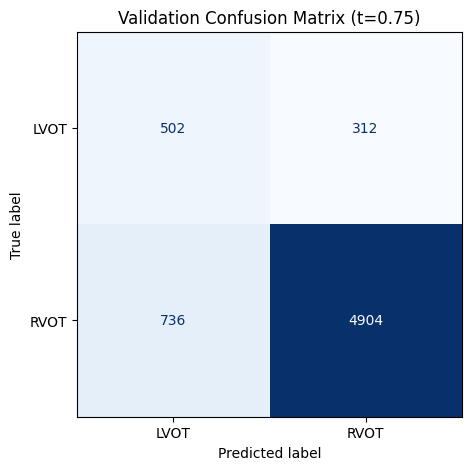

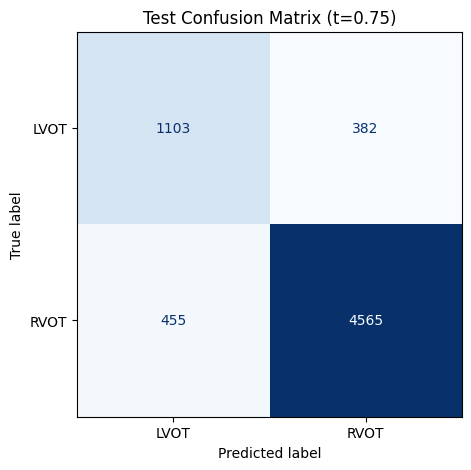

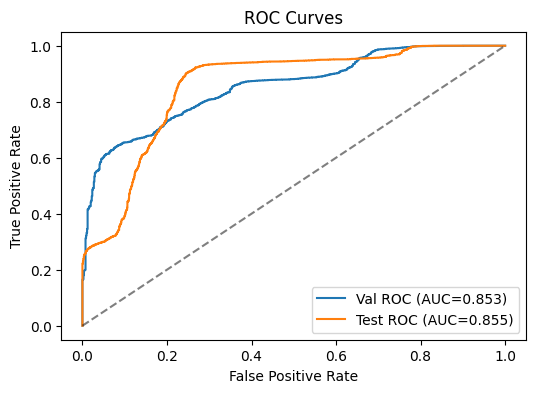

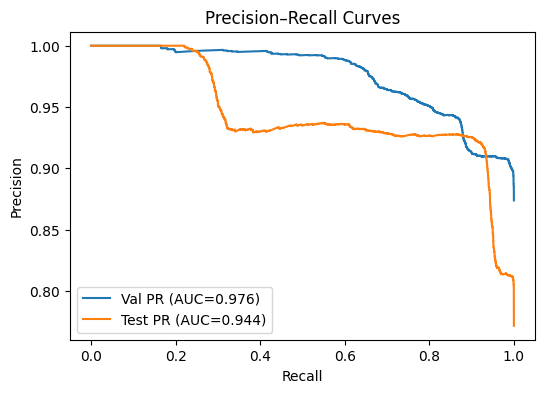

In [9]:
best_model = xgb.XGBClassifier()
best_model.load_model('outputs/xgb_macro_f1_best_model_B.bin')

evaluate_with_auto_threshold(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    calibrate=True,
)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_B, y_train_B)
print(classification_report(y_test_B, lr.predict(X_test_B)))